In [18]:
from keras.models import Sequential, load_model
from keras.layers import *
from keras import optimizers, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, Callback

# telegram
import telegram

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
from sklearn.utils import shuffle 

# Used for graph export
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

import pickle as pkl
import h5py

from pathlib import Path
import os.path
import sys
import datetime
import time
import math

In [2]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [3]:
smartphones = ["N5X"]
window_size = 25
constant_pixels = 0.06
HDF5_PATH = str(Path.home())+"/data/hdf/"+smartphones[0]+"-win"+str(window_size)+".hdf"

In [4]:
def myGenerator(set_name, batch_size):
    """
    This generator returns images
    """
    hdf = h5py.File(HDF5_PATH, "r")

    pSensors = hdf[set_name + "/sensors"]
    pLabels = hdf[set_name + "/labels"]

    len_train = pSensors.shape[0]
    
    randomBatchOrder = np.arange(len_train // batch_size)

    while True:
        np.random.shuffle(randomBatchOrder) 
        
        for i in range(len_train // batch_size):
            idx = randomBatchOrder[i]
            shuffled = shuffle(pSensors[idx * batch_size: (idx+1) * batch_size], pLabels[idx * batch_size: (idx+1) * batch_size])
            yield shuffled[0].reshape(-1, train_x.shape[1], train_x.shape[2]), shuffled[1].reshape(-1, train_y.shape[1])
            
# (n_frames, n_values, 1); labels

In [5]:
hdf = h5py.File(HDF5_PATH, "r")

train_x = hdf["train/sensors"]
train_y = hdf["train/labels"]

test_x = hdf["test/sensors"]
test_y = hdf["test/labels"]

In [6]:
## ConvLSTM net hyperparameters
numFilters1 = 128 # number of filters in first Conv2D layer
numFilters2 = 64 # number of filters in second Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = (3, 3)
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 512
numNueronsFCL2 = 128
# number of epochs
epochs = 9999
# batchsize
batch_size = 200
# number of total clases
# dropout ratio for dropout layer
dropOutRatio = 0.5

model_name="IMU_N5X_20190116_203310.61-399.61.h5"

In [45]:
%%time
with tf.device('/device:GPU:1'):
    tf.get_default_graph()
    model = Sequential()
    model.add(LSTM(128, input_shape=(None, train_x.shape[2]), return_sequences=True))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(BatchNormalization(axis=-1))
    model.add(Dropout(0.5))
    model.add(Dense(2, kernel_regularizer=regularizers.l2(0.01)))
    model.load_weights(str(Path.home())+"/data/models/"+model_name)

    ## Compiling the model to generate a model
    def eucInMM(y_true, y_pred):
        return (K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))) * constant_pixels
    def euc(y_true, y_pred):
        return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))

    optimizer = optimizers.Adam(lr = 0.001, decay=1e-6)
    #optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)
    model.compile(loss=rmse, optimizer=optimizer, metrics=[eucInMM ,rmse, euc])

    hist = model.predict_generator(myGenerator("test", batch_size),steps = len(test_x) // batch_size)#, batch_size=batch_size)

CPU times: user 1min 22s, sys: 4.87 s, total: 1min 27s
Wall time: 1min 30s


In [54]:
df = pd.DataFrame(np.concatenate([hist, test_y[:len(hist)]], axis=1), columns=["XPred","YPred", "X", "Y"])
df.XPred = df.XPred.astype(int)
df.YPred = df.YPred.astype(int)

indices = df.ne(df.shift()).apply(lambda x: x.index[x].tolist())

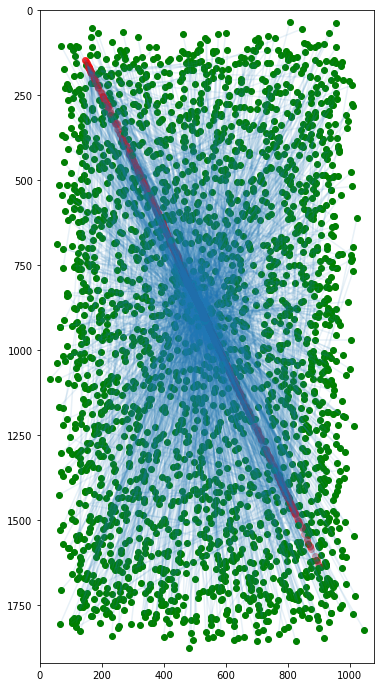

In [55]:
fig, ax = plt.subplots(figsize=(6,12))
ax.set_xlim(0, 1080)
ax.set_ylim(1920, 0)
for x in indices.X[1:]:
    x_true=df.iloc[x-1]['X']
    y_true=df.iloc[x-1]['Y']
    x_pred=df.iloc[x-1]['XPred']
    y_pred=df.iloc[x-1]['YPred']
    ax.scatter([x_pred],[y_pred], c='red', alpha = 0.3)
    ax.scatter([x_true],[y_true], c='green')
    l = mlines.Line2D([x_true,x_pred],[y_true,y_pred],alpha=0.1)
    ax.add_line(l)

In [31]:
def calculate_euc(row):
    return math.sqrt((row['XPred'] - row['YPred'])**2 + (row['X'] - row['Y'])**2)

def calculate_eucMM(row):
    return row['euc'] * constant_pixels
    
def calculate_x_error(row):
    return abs(row["XPred"]-row["X"])

def calculate_y_error(row):
    return abs(row["YPred"]-row["Y"])

In [32]:
df['euc'] = df.apply(calculate_euc, axis=1)
df['eucMM'] = df.apply(calculate_eucMM, axis=1)
df['x_err'] = df.apply(calculate_x_error, axis=1)
df['y_err'] = df.apply(calculate_y_error, axis=1)

In [33]:
df.describe()

,XPred,YPred,X,Y,euc,eucMM,x_err,y_err
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,557.232600,952.906860,488.119380,912.325000,747.096593,44.825796,245.903940,438.454580
std,54.617467,107.704482,273.496638,529.378561,354.026922,21.241615,140.172835,243.966068
min,274.000000,387.000000,80.000000,69.000000,119.218287,7.153097,0.000000,0.000000
25%,527.000000,891.000000,252.000000,412.000000,464.226238,27.853574,140.000000,253.000000
50%,555.000000,948.000000,462.000000,882.000000,636.123416,38.167405,242.000000,443.000000
75%,586.000000,1011.000000,735.000000,1389.000000,961.462428,57.687746,357.000000,618.000000
max,781.000000,1392.000000,1024.000000,1847.000000,1752.146113,105.128767,669.000000,1210.000000
